In [1]:
from os.path import join,expanduser
import sys
import cmocean as cmo
# identify user's home directory
user_home_dir = expanduser('~')
# import the ECCOv4 py library 
sys.path.insert(0,join(user_home_dir,'ECCOv4-py'))
import ecco_v4_py as ecco
import botocore
import boto3
from boto3.session import Session
import cmocean
from collections import Counter
from dask.distributed import Client
import datetime
import fsspec
from gc import get_referents
import json
from matplotlib import colors as mcolors
from matplotlib.cm import ScalarMappable
import numpy as np
from pathlib import Path
from pprint import pprint
import requests
import s3fs
import sys
from sys import getsizeof
import time as time
from types import ModuleType, FunctionType
import xarray as xr
import matplotlib.pyplot as plt
import zarr
import sys
sys.path.append('/efs_ecco/ECCO/EMU/emu_userinterface_dir/')
import emu_plot_arg_py as ept
import plot_budg



In [2]:
### 1. Load the grid to find lat/lon of tiles ------------------
ecco_grid = xr.open_dataset('/efs_ecco/ECCO/V4/r4/ECCO_L4_GEOMETRY_LLC0090GRID_V4R4/GRID_GEOMETRY_ECCO_V4r4_native_llc0090.nc')
ecco_grid.load()
lonwest   = [];loneast = [];latsouth = [];latnorth = []
for t in [0,3,9,12]:
    print("I am in tile",t)
    lon   = ecco_grid.XC[t,:,:];lat = ecco_grid.YC[t,:,:]
    lonw  = float(lon.min());lone = float(lon.max())
    lats  = float(lat.min());latn = float(lat.max())
    lonwest.append(lonw);loneast.append(lone)
    latsouth.append(lats);latnorth.append(latn)

# lon/lats of tiles
lonwest   = [-111.6064682006836, 52.5, -179.96746826171875, -127.5];lonwest[2] = 135
loneast   = [64.81916809082031, 141.5, 179.98690795898438, -38.5];loneast[2]=-135
## FINAL LON/ LAT LISTS (for EMU use)
lonwest   = [-111.6064682006836, 52.5, 135, -127.5]
loneast   = [64.81916809082031, 141.5, -135, -38.5]
latsouth  = [-89.87305450439453, -88.10266876220703, -89.87305450439453, -88.10266876220703]
latnorth  = [-57.27140808105469, -57.27140808105469, -57.27140808105469, -57.27140808105469]


I am in tile 0
I am in tile 3
I am in tile 9
I am in tile 12


In [3]:
##2.Extract the Heat Budget terms 
## ------ 3. lon/lats of the SO Tiles 
lonwest   = [-111.6, 52.5, 135.0, -127.5]
loneast   = [64.8, 141.5, -135.0, -38.5]
latsouth  = [-89.9, -88.1, -89.9, -88.1]
latnorth  = [-57.3, -57.3, -57.3, -57.3]
tiles     = [0,3,9,12] #list of tiles
t         = 0 ##choose the tile interested
lon1      = lonwest[t] ;
lon2      = loneast[t]
lat1      = latsouth[t];
lat2      = latnorth[t];
deep      = 300.0;shallow=0.0
## Open the heat budget file & variables
globals_dict     = ept.emu_plot(run_name=f"/efs_ecco/sdarma/ECCO/EMU/SOWARM/emu_budg_m_2_{lon1}_{lon2}_{lat1}_{lat2}_{deep}_{shallow}")
return_vars_dict = globals_dict.get('return_vars')


Found file: /efs_ecco/ECCO/EMU/emu_userinterface_dir/emu_env.singularity
EMU Input Files directory: /efs_ecco/ECCO/EMU2/emu_input_dir

Specified directory of EMU run to examine: /efs_ecco/sdarma/ECCO/EMU/SOWARM/emu_budg_m_2_-111.6_64.8_-89.9_-57.3_300.0_0.0

Reading /efs_ecco/sdarma/ECCO/EMU/SOWARM/emu_budg_m_2_-111.6_64.8_-89.9_-57.3_300.0_0.0

Reading Budget Tool output ... 
*********************************************
Read sum of heat budget variables 
   budg_tend: tendency time-series (per second)
   budg_tend_name: name of variables in budg_tend
from file /efs_ecco/sdarma/ECCO/EMU/SOWARM/emu_budg_m_2_-111.6_64.8_-89.9_-57.3_300.0_0.0/output/emu_budg.sum_tend

*********************************************
Read sum of heat budget variables
   budg_tint: time-integrated tendency time-series
   budg_tint_name: name of variables in budg_tint
from file /efs_ecco/sdarma/ECCO/EMU/SOWARM/emu_budg_m_2_-111.6_64.8_-89.9_-57.3_300.0_0.0/output/emu_budg.sum_tint

****************************

In [4]:
##3. Extract the Heat Budget terms
tt       = return_vars_dict['time_values']
lhs_tend = return_vars_dict['lhs_tendency']
rhs_tend = return_vars_dict['rhs_tendency']
lhs_tint = return_vars_dict['lhs_tendency_time_integral']
rhs_tint = return_vars_dict['rhs_tendency_time_integral']
emu_tend = return_vars_dict['emu_tend']
adv_tend = return_vars_dict['adv_tendency']
mix_tend = return_vars_dict['mix_tendency']
frc_tend = return_vars_dict['frc_tendency']
adv_tint = return_vars_dict['adv_tendency_time_integral']
mix_tint = return_vars_dict['mix_tendency_time_integral']
frc_tint = return_vars_dict['frc_tendency_time_integral']
#budg_mkup = return_vars_dict['list_flux_obj'];nvar = return_vars_dict['total_num_var'];fbudg = return_vars_dict['budg_quantity']
#ibud = return_vars_dict['budg_quantity_idx']; nmonths = return_vars_dict['num_months']emu_tend_name = return_vars_dict['budg_tend_name']
#nmkup = return_vars_dict['num_flux']

## 4. Do the 1992-2016 Climatology of Heat Budget terms
lhs_tend_reshaped = lhs_tend.reshape((26, 12))  # shape: (years, months)
lhs_climatology   = lhs_tend_reshaped.mean(axis=0)  # shape: (12,)
frc_tend_reshaped = frc_tend.reshape((26, 12))  # shape: (years, months)
frc_climatology   = frc_tend_reshaped.mean(axis=0)  # shape: (12,)
adv_tend_reshaped = adv_tend.reshape((26, 12))  # shape: (years, months)
adv_climatology   = adv_tend_reshaped.mean(axis=0)  # shape: (12,)
mix_tend_reshaped = mix_tend.reshape((26, 12))  # shape: (years, months)
mix_climatology   = mix_tend_reshaped.mean(axis=0)  # shape: (12,)


In [7]:
##5.Do the heat budget anomalies relative to the climatology
t1      = 300; t2=313 ##2016       ####t1=300;t2=313 for feb 2017 event 
lhs17   = lhs_tend[t1:t2];lhsanom17 = lhs17 - lhs_climatology
frc17   = frc_tend[t1:t2];frcanom17 = frc17 - frc_climatology
adv17   = adv_tend[t1:t2];advanom17 = adv17 - adv_climatology
mix17   = mix_tend[t1:t2];mixanom17 = mix17 - mix_climatology
###-------------- Do the anomalies of 2016 relative 1992-2016 ----------------------------
t1      = 288; t2=300 ##2007             ##t1=288;t2=300
lhs16   = lhs_tend[t1:t2];lhsanom16 = lhs16 - lhs_climatology
frc16   = frc_tend[t1:t2];frcanom16 = frc16 - frc_climatology
adv16   = adv_tend[t1:t2];advanom16 = adv16 - adv_climatology
mix16   = mix_tend[t1:t2];mixanom16 = mix16 - mix_climatology

lhsanom = np.concatenate([lhsanom16, lhsanom17])
frcanom = np.concatenate([frcanom16, frcanom17])
advanom = np.concatenate([advanom16, advanom17])
mixanom = np.concatenate([mixanom16, mixanom17])


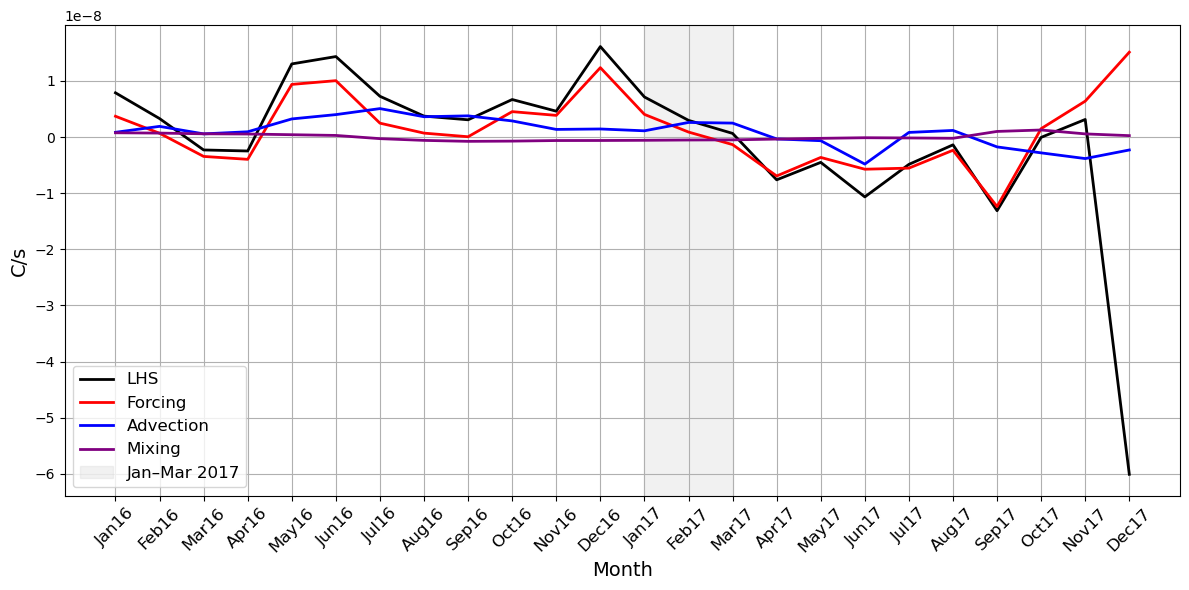

In [13]:
#6. PLot the anomalous Heat budget timeseries 
vars    = [lhsanom,frcanom,advanom,mixanom]
labels  = ['LHS', 'Forcing', 'Advection', 'Mixing']
colors  = ['black', 'red', 'blue', 'purple']
months  = ['Jan16', 'Feb16', 'Mar16', 'Apr16', 'May16', 'Jun16','Jul16', 'Aug16', 'Sep16', 'Oct16', 'Nov16', 'Dec16','Jan17', 'Feb17', 'Mar17', 'Apr17', 'May17', 'Jun17','Jul17', 'Aug17', 'Sep17', 'Oct17', 'Nov17', 'Dec17']
# find the integer positions of Jan17 and Mar17
start   = months.index('Jan17')   # 12
end     = months.index('Mar17')   # 14

plt.figure(figsize = (12, 6))
for i in range(len(vars)):
    plt.plot(range(24), vars[i], label=labels[i], color=colors[i], linewidth=2)
plt.xticks(ticks=range(24), labels= months, fontsize=12,rotation=45)
plt.axvspan(start, end, color='lightgray', alpha=0.3, label='Jan–Mar 2017')
plt.xlabel('Month', fontsize=14)
plt.ylabel('C/s', fontsize=14)#plt.title('Time Series of EMU Budget Terms', fontsize=16)
plt.legend(fontsize=12)
plt.grid(True)
plt.tight_layout()


Found file: /efs_ecco/ECCO/EMU/emu_userinterface_dir/emu_env.singularity
EMU Input Files directory: /efs_ecco/ECCO/EMU2/emu_input_dir

Specified directory of EMU run to examine: /efs_ecco/sdarma/ECCO/EMU/SOWARM/emu_budg_m_2_-127.5_-38.5_-88.1_-57.3_50.0_0.0

Reading /efs_ecco/sdarma/ECCO/EMU/SOWARM/emu_budg_m_2_-127.5_-38.5_-88.1_-57.3_50.0_0.0

Reading Budget Tool output ... 
*********************************************
Read sum of heat budget variables 
   budg_tend: tendency time-series (per second)
   budg_tend_name: name of variables in budg_tend
from file /efs_ecco/sdarma/ECCO/EMU/SOWARM/emu_budg_m_2_-127.5_-38.5_-88.1_-57.3_50.0_0.0/output/emu_budg.sum_tend

*********************************************
Read sum of heat budget variables
   budg_tint: time-integrated tendency time-series
   budg_tint_name: name of variables in budg_tint
from file /efs_ecco/sdarma/ECCO/EMU/SOWARM/emu_budg_m_2_-127.5_-38.5_-88.1_-57.3_50.0_0.0/output/emu_budg.sum_tint

****************************

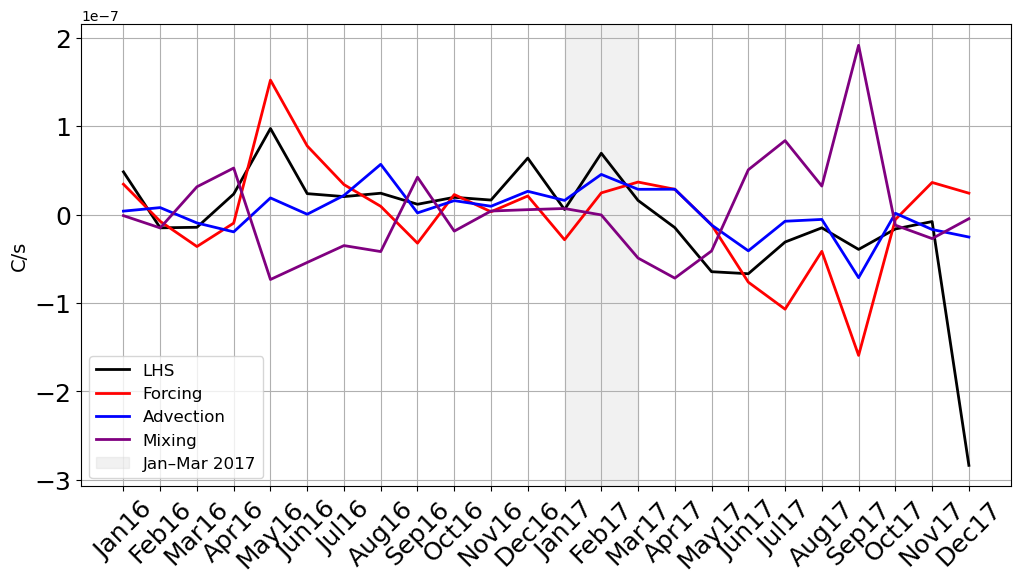

In [11]:
#7. ----Extract the heat budget terms & plot them full script ---
lonwest   = [-111.6, 52.5, 135.0, -127.5]
loneast   = [64.8, 141.5, -135.0, -38.5]
latsouth  = [-89.9, -88.1, -89.9, -88.1]
latnorth  = [-57.3, -57.3, -57.3, -57.3]
tiles     = [0,3,9,12] #list of tiles
t         = 3 ##choose the tile interested
lon1      = lonwest[t] ;
lon2      = loneast[t]
lat1      = latsouth[t];
lat2      = latnorth[t];
deep      = 50.0;shallow=0.0
## Open the heat budget file & variables
globals_dict     = ept.emu_plot(run_name=f"/efs_ecco/sdarma/ECCO/EMU/SOWARM/emu_budg_m_2_{lon1}_{lon2}_{lat1}_{lat2}_{deep}_{shallow}")
return_vars_dict = globals_dict.get('return_vars')
### Extract  the variables
tt       = return_vars_dict['time_values']
lhs_tend = return_vars_dict['lhs_tendency']
rhs_tend = return_vars_dict['rhs_tendency']
lhs_tint = return_vars_dict['lhs_tendency_time_integral']
rhs_tint = return_vars_dict['rhs_tendency_time_integral']
emu_tend = return_vars_dict['emu_tend']
adv_tend = return_vars_dict['adv_tendency']
mix_tend = return_vars_dict['mix_tendency']
frc_tend = return_vars_dict['frc_tendency']
adv_tint = return_vars_dict['adv_tendency_time_integral']
mix_tint = return_vars_dict['mix_tendency_time_integral']
frc_tint = return_vars_dict['frc_tendency_time_integral']
#budg_mkup = return_vars_dict['list_flux_obj'];nvar = return_vars_dict['total_num_var'];fbudg = return_vars_dict['budg_quantity']
#ibud = return_vars_dict['budg_quantity_idx']; nmonths = return_vars_dict['num_months']emu_tend_name = return_vars_dict['budg_tend_name']
#nmkup = return_vars_dict['num_flux']

## 4.-------- ---------- DO the 1992-2016 Climatology---------------------------
lhs_tend_reshaped = lhs_tend.reshape((26, 12))  # shape: (years, months)
lhs_climatology   = lhs_tend_reshaped.mean(axis=0)  # shape: (12,)
frc_tend_reshaped = frc_tend.reshape((26, 12))  # shape: (years, months)
frc_climatology   = frc_tend_reshaped.mean(axis=0)  # shape: (12,)
adv_tend_reshaped = adv_tend.reshape((26, 12))  # shape: (years, months)
adv_climatology   = adv_tend_reshaped.mean(axis=0)  # shape: (12,)
mix_tend_reshaped = mix_tend.reshape((26, 12))  # shape: (years, months)
mix_climatology   = mix_tend_reshaped.mean(axis=0)  # shape: (12,)

###----------- DO THE ANOMALIES OF 2017 relative to the 1992-2016 --------------------
t1      = 300; t2=313 ##2006       ####t1=300;t2=313 for feb 2017 event 
lhs17   = lhs_tend[t1:t2];lhsanom17 = lhs17 - lhs_climatology
frc17   = frc_tend[t1:t2];frcanom17 = frc17 - frc_climatology
adv17   = adv_tend[t1:t2];advanom17 = adv17 - adv_climatology
mix17   = mix_tend[t1:t2];mixanom17 = mix17 - mix_climatology
###-------------- Do the anomalies of 2016 relative 1992-2016 ----------------------------
t1      = 288; t2=300 ##2007             ##t1=288;t2=300
lhs16   = lhs_tend[t1:t2];lhsanom16 = lhs16 - lhs_climatology
frc16   = frc_tend[t1:t2];frcanom16 = frc16 - frc_climatology
adv16   = adv_tend[t1:t2];advanom16 = adv16 - adv_climatology
mix16   = mix_tend[t1:t2];mixanom16 = mix16 - mix_climatology

lhsanom = np.concatenate([lhsanom16, lhsanom17])
frcanom = np.concatenate([frcanom16, frcanom17])
advanom = np.concatenate([advanom16, advanom17])
mixanom = np.concatenate([mixanom16, mixanom17])

##----Plot the heat budget term anomalies ----------
vars    = [lhsanom,frcanom,advanom,mixanom]
labels  = ['LHS', 'Forcing', 'Advection', 'Mixing']
colors  = ['black', 'red', 'blue', 'purple']
months  = ['Jan16', 'Feb16', 'Mar16', 'Apr16', 'May16', 'Jun16','Jul16', 'Aug16', 'Sep16', 'Oct16', 'Nov16', 'Dec16','Jan17', 'Feb17', 'Mar17', 'Apr17', 'May17', 'Jun17','Jul17', 'Aug17', 'Sep17', 'Oct17', 'Nov17', 'Dec17']
# find the integer positions of Jan17 and Mar17
start   = months.index('Jan17')   # 12
end     = months.index('Mar17')   # 14
plt.figure(figsize=(12, 6))
for i in range(len(vars)):
    plt.plot(range(24), vars[i], label=labels[i], color=colors[i], linewidth=2)
plt.xticks(ticks=range(24), labels=months, fontsize=12,rotation=45)
plt.axvspan(start, end, color='lightgray', alpha=0.3, label='Jan–Mar 2017')
#plt.xlabel('Month', fontsize=14)
plt.ylabel('C/s', fontsize=14)#plt.title('Time Series of EMU Budget Terms', fontsize=16)
plt.legend(fontsize=12)
plt.tick_params(axis='both', labelsize=18)
plt.grid(True)
plt.savefig(f'/home/jovyan/efs_ecco/sdarma/FIGURES/HEAT_BUDGET_{tiles[t]}_{lon1}_{lon2}_{lat1}_{lat2}_{deep}_{shallow}.png',dpi=200)